This notebook begins showcasing how we deal with uncertainty in our model with the publication Merdith et al. (2019). As there are a number of steps in the process (including making rasters through GMT) and the calculation is time conusming (3–4 hours for one full run) it is not feasible to pass the full distribution at a mid-ocean ridge through our calculation in order to then propogate it at a subduction zone. Instead, we will define distributions in three ways: (1) per spreading rate ('Individual'); (2) per spreading-rate classification ('Batch'), and; (2) for all spreading rates ('Full'). We then pass a mean value (of carbon storage or serpentinite thickness, or any variable of interest) AND the spreading rate of formation, into our calcualtion to propogate it through in the model run. Then, when we interface with a subduction zone we will recover the spreading rate of formation as a key to find the corresponding expected distribution using the desired method, which can then be used to perturb the mean value using that distribution.

Large parts of this process were originally done by Suzanne Atkins (suzanne.atkins@ens.fr, github.com/seatkins).

References

Merdith, A.S., Atkins, S.E., and Tetley, M.G. (2019). Tectonic controls on carbon and serpentinite storage in subducted upper oceanic lithosphere for the past 320 Ma. Frontiers: Earth Science.

In [1]:
import numpy as np
import pygplates as gplates
import pandas as pd
import MOR_characterisation_serp_flux_FINAL, distribution_calculator
import pickle
from scipy import interpolate
from collections import defaultdict
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as st

/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1066: UserWarning: Duplicate key in file "/Users/Andrew/.matplotlib/matplotlibrc", line #3
  (fname, cnt))
/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1066: UserWarning: Duplicate key in file "/Users/Andrew/.matplotlib/matplotlibrc", line #4
  (fname, cnt))


In [2]:
savedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/'

In [3]:
samples = 10000
tsteps = 100
per = np.zeros([tsteps,samples])
volcanic_percent = np.zeros([tsteps, samples])
thickness = np.zeros([tsteps,samples]) # depth of serpentinisation
tmp_DS = np.zeros([tsteps,samples]) # degree of serpentinisation
carbon_max = np.zeros([tsteps,samples])
C_gabbro = np.zeros([tsteps,samples])
upper_volc_thickness = np.zeros([tsteps,samples])
lower_volc_thickness = np.zeros([tsteps,samples])
transition_thickness = np.zeros([tsteps,samples])
sheeted_dykes_thickness = np.zeros([tsteps,samples])
upper_volc_C = np.zeros([tsteps,samples])
lower_volc_C = np.zeros([tsteps,samples])
transition_C = np.zeros([tsteps,samples])
sheeted_dykes_C = np.zeros([tsteps,samples])
gabbros_thickness = np.zeros([tsteps,samples])
C_volcanic = np.zeros([tsteps,samples])
C_thickness_serpentinites = np.zeros([tsteps,samples])
C_thickness_volcanics = np.zeros([tsteps,samples])
C_total = np.zeros([tsteps,samples])
serp_thickness = np.zeros([tsteps, samples])
velocity = np.zeros([tsteps,samples])
bottom_water_temperature = np.zeros([tsteps,samples])

for j in range(1,tsteps+1):
    i = j-1
    #print('Spreading =',j), i
         
    velocity[i,::]=np.ones(samples)*j
    bottom_water_temperature[i,::] = np.ones(samples)*12
    
    per[i,::] = MOR_characterisation_serp_flux_FINAL.SR_and_peridotite(samples, velocity[i,::])
    volcanic_percent[i,::] = 100 - per[i,::]
    
    if j <= 40:
        thickness[i,::] = MOR_characterisation_serp_flux_FINAL.SR_and_thickness_slow_ultraslow(samples)
        tmp_DS[i,::] = MOR_characterisation_serp_flux_FINAL.SR_and_dsSurf_slow_ultraslow(samples,
                                                                                            velocity[i,::], 
                                                                                            np.squeeze(thickness[i,::]))          
        carbon_max[i,::], C_gabbro[i,::] = MOR_characterisation_serp_flux_FINAL.carbon_content_slow_ultraslow(samples,
                                                                                                              velocity[i,::])
        upper_volc_thickness[i,::] = lower_volc_thickness[i,::] = transition_thickness[i,::]= sheeted_dykes_thickness[i,::] = 0
        upper_volc_C[i,::] = lower_volc_C[i,::] = transition_C[i,::] = sheeted_dykes_C[i,::] = 0
        gabbros_thickness[i,::] = thickness[i,::] * volcanic_percent[i,::] * 0.01
        C_gabbro[i,C_gabbro[i,::]<0] = 0
        C_gabbro[i,::] = C_gabbro[i,::] * 12./44.
        C_volcanic[i,::] = gabbros_thickness[i,::] * C_gabbro[i,::]
        
        
    else:
    # fast ridges     
        tmp_DS[i,::] = MOR_characterisation_serp_flux_FINAL.SR_and_dsSurf_inter_fast(samples,
                                                                                        velocity[i,::])
        thickness[i,::], upper_volc_thickness[i,::], lower_volc_thickness[i,::],transition_thickness[i,::],sheeted_dykes_thickness[i,::],gabbros_thickness[i,::] = \
            MOR_characterisation_serp_flux_FINAL.SR_and_thickness_inter_fast(samples,
                                                                             np.squeeze(tmp_DS[i,::]),
                                                                             volcanic_percent[i,::])


        upper_volc_C[i,::], lower_volc_C[i,::], transition_C[i,::], sheeted_dykes_C[i,::], C_gabbro[i,::], bottom_water_temperature_multiplier = \
                        MOR_characterisation_serp_flux_FINAL.carbon_content_inter_fast(samples,
                                                                                       velocity[i,::],
                                                                                       bottom_water_temperature[i,::])

        #translate to carbon from CO2
        upper_volc_C[i,::] = upper_volc_C[i,::] * 12./44.
        lower_volc_C[i,::] = lower_volc_C[i,::] * 12./44.
        transition_C[i,::] = transition_C[i,::] * 12./44.
        sheeted_dykes_C[i,::] = sheeted_dykes_C[i,::] * 12./44.
        C_gabbro[i,::] = C_gabbro[i,::] * 12./44.
        
        C_gabbro[i,C_gabbro[i,::]<0] = 0
        
        #wt% carbon stored in all volcanics summed
        C_volcanic[i,::] =  (upper_volc_thickness[i,::] * upper_volc_C[i,::] + \
                          lower_volc_thickness[i,::] * lower_volc_C[i,::] + \
                          transition_thickness[i,::] * transition_C[i,::] + \
                          sheeted_dykes_thickness[i,::] * sheeted_dykes_C[i,::] + \
                          gabbros_thickness[i,::] * C_gabbro[i,::]) / (thickness[i,::] * volcanic_percent[i,::]/100.)
        carbon_max[i,::] = 0.32
        
    C_volcanic[i,C_volcanic[i,::]<0] = 0

    max_DS = 100
    m = carbon_max[i,::]/max_DS
    
    serp_thickness[i,::] = thickness[i,::] * per[i,::] * 0.01 * 1000./865. * tmp_DS[i,::] * 0.01
        
    C_thickness_serpentinites[i,::] = thickness[i,::] * per[i,::] * 0.01 * 1000.0/865.0 * tmp_DS[i,::] * m * 0.01 * 12./44.
              
    C_thickness_volcanics[i,::] = thickness[i,::] * volcanic_percent[i,::] * 0.01 * C_volcanic[i,::] * 0.01

    C_total[i,::] = C_thickness_serpentinites[i,::] + C_thickness_volcanics[i,::] * 0.8

In [9]:
#maybe a second way
ultraslow_C = np.random.choice(C_total[:20].flatten(), 10000)
slow_C = np.random.choice(C_total[20:40].flatten(), 10000)
intermediate_C = np.random.choice(C_total[40:70].flatten(), 10000)
fast_C = np.random.choice(C_total[70:].flatten(), 10000)

ultraslow_Serp = np.random.choice(serp_thickness[:20].flatten(), 10000)
slow_Serp = np.random.choice(serp_thickness[20:40].flatten(), 10000)
intermediate_Serp = np.random.choice(serp_thickness[40:70].flatten(), 10000)
fast_Serp = np.random.choice(serp_thickness[70:].flatten(), 10000)

ultraslow_Upper = np.random.choice(upper_volc_thickness[:20].flatten(), 10000)
slow_Upper = np.random.choice(upper_volc_thickness[20:40].flatten(), 10000)
intermediate_Upper = np.random.choice(upper_volc_thickness[40:70].flatten(), 10000)
fast_Upper = np.random.choice(upper_volc_thickness[70:].flatten(), 10000)

ultraslow_Gabbro = np.random.choice(gabbros_thickness[:20].flatten(), 10000)
slow_Gabbro = np.random.choice(gabbros_thickness[20:40].flatten(), 10000)
intermediate_Gabbro = np.random.choice(gabbros_thickness[40:70].flatten(), 10000)
fast_Gabbro = np.random.choice(gabbros_thickness[70:].flatten(), 10000)

ultraslow_Total = np.random.choice(thickness[:20].flatten(), 10000)
slow_Total = np.random.choice(thickness[20:40].flatten(), 10000)
intermediate_Total = np.random.choice(thickness[40:70].flatten(), 10000)
fast_Total = np.random.choice(thickness[70:].flatten(), 10000)



In [70]:
C_batch_uncertainty = np.vstack((ultraslow_C, slow_C,intermediate_C,fast_C))
S_batch_uncertainty = np.vstack((ultraslow_Serp,slow_Serp,intermediate_Serp,fast_Serp))
U_batch_uncertainty = np.vstack((ultraslow_Upper,slow_Upper,intermediate_Upper,fast_Upper))
G_batch_uncertainty = np.vstack((ultraslow_Gabbro,slow_Gabbro,intermediate_Gabbro,fast_Gabbro))
T_batch_uncertainty = np.vstack((ultraslow_Total,slow_Total,intermediate_Total,fast_Total))


In [71]:
#save arrays as pickle dumps, this is what we will use for uncertainty later in the method
#this is for individual spreading rate, cell below for batched spreading rates
#individual
carbon_filename = 'C_total_array_individual'
serp_filename = 'Serp_thickness_array_individual'
upper_filename = 'Upper_thickness_array_individual'
gabbro_filename = 'Gabb_thickness_array_individual'
total_thick_filename = 'Total_thickness_array_individual'

#with open('%s%s.pkl' % (savedir, carbon_filename),'wb') as f:
#     pickle.dump(C_total, f)
#        
#with open('%s%s.pkl' % (savedir, serp_filename),'wb') as f:
#     pickle.dump(serp_thickness, f)
#        
#with open('%s%s.pkl' % (savedir, gabbro_filename),'wb') as f:
#     pickle.dump(gabbros_thickness, f)
#        
#with open('%s%s.pkl' % (savedir, upper_filename),'wb') as f:
#    pickle.dump(upper_volc_thickness, f)
#    
#with open('%s%s.pkl' % (savedir, total_thick_filename),'wb') as f:
#    pickle.dump(thickness, f)    
    

In [73]:
#save arrays as pickle dumps, this is what we will use for uncertainty later in the method
#this is for individual spreading rate, cell below for batched spreading rates
#batch
carbon_filename = 'C_total_array_batch'
serp_filename = 'Serp_thickness_array_batch'
upper_filename = 'Upper_thickness_array_batch'
gabbro_filename = 'Gabb_thickness_array_batch'
total_thick_filename = 'Total_thickness_array_batch'

with open('%s%s.pkl' % (savedir, carbon_filename),'wb') as f:
     pickle.dump(C_batch_uncertainty, f)
        
with open('%s%s.pkl' % (savedir, serp_filename),'wb') as f:
     pickle.dump(S_batch_uncertainty, f)
        
with open('%s%s.pkl' % (savedir, gabbro_filename),'wb') as f:
     pickle.dump(G_batch_uncertainty, f)
        
with open('%s%s.pkl' % (savedir, upper_filename),'wb') as f:
    pickle.dump(U_batch_uncertainty, f)
    
with open('%s%s.pkl' % (savedir, total_thick_filename),'wb') as f:
    pickle.dump(T_batch_uncertainty, f)    
   

In [23]:
#
#if we want to visualise some of our results, see below panels
#

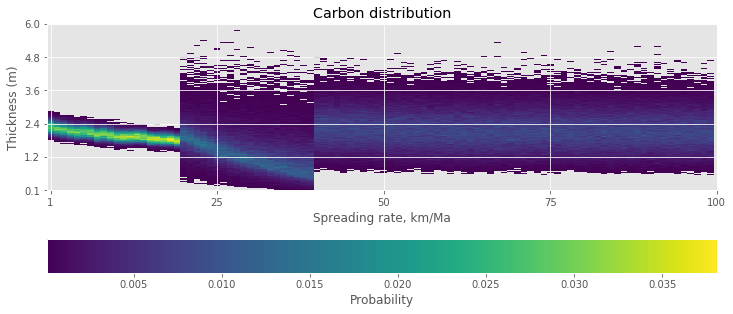

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
C_total_hist = np.zeros([100,500])
bins = np.linspace(np.min(C_total),np.max(C_total),501)
for i in range(0,100):
    C_total_hist[i,::],bin_edges_C = np.histogram(C_total[i,::],bins=bins)
C_total_hist[C_total_hist == 0.0] = np.nan
im = ax.imshow(C_total_hist.T/samples,aspect=0.05)

ax.set_xticks(np.arange(0,101,25))
ax.set_xticklabels([1, 25, 50, 75, 100])
ax.set_yticks(np.arange(0,501,100))
ax.set_yticklabels([np.round(t*1000,decimals=1) for t in bin_edges_C[0:501:100]])
ax.invert_yaxis()
ax.set_xlabel('Spreading rate, km/Ma')
ax.set_ylabel('Thickness (m)')
ax.set_title('Carbon distribution')
cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
cbar.ax.set_yticklabels(['0','1','2','>3'])
cbar.set_label('Probability')

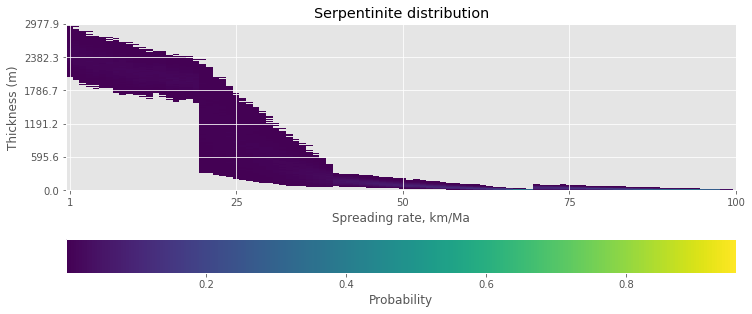

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
serp_thick_hist = np.zeros([100,500])
bins = np.linspace(np.min(serp_thickness),np.max(serp_thickness),501)
for i in range(0,100):
    serp_thick_hist[i,::],bin_edges_S = np.histogram(serp_thickness[i,::],bins=bins)
serp_thick_hist[serp_thick_hist == 0.0] = np.nan
im = ax.imshow(serp_thick_hist.T/samples,aspect=0.05)

ax.set_xticks(np.arange(0,101,25))
ax.set_xticklabels([1, 25, 50, 75, 100])
ax.set_yticks(np.arange(0,501,100))
ax.set_yticklabels([np.round(t*1000,decimals=1) for t in bin_edges_S[0:501:100]])
#ax.set_yticks(np.arange(0,501,100),[np.format_float_scientific(t,2) for t in bin_edges_S[0:501:100]])
ax.invert_yaxis()
ax.set_xlabel('Spreading rate, km/Ma')
ax.set_ylabel('Thickness (m)')
ax.set_title('Serpentinite distribution')
cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
cbar.ax.set_yticklabels(['0','1','2','>3'])
cbar.set_label('Probability')

The below two panels plot the histogram of each slice.

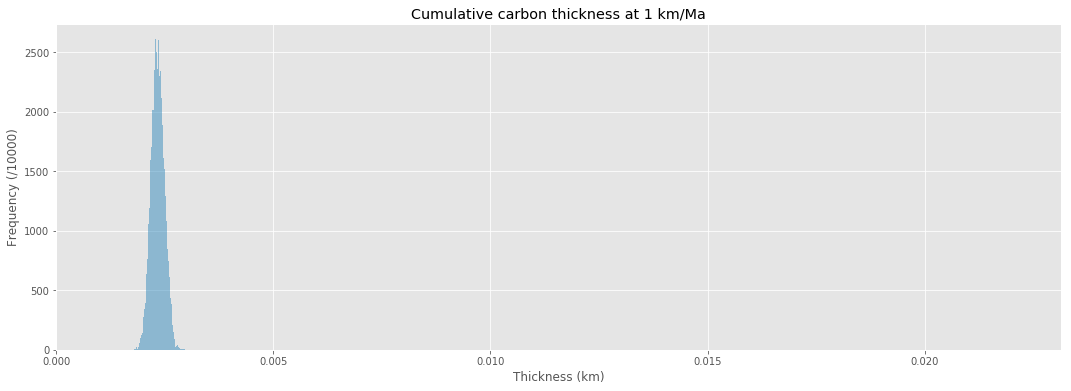

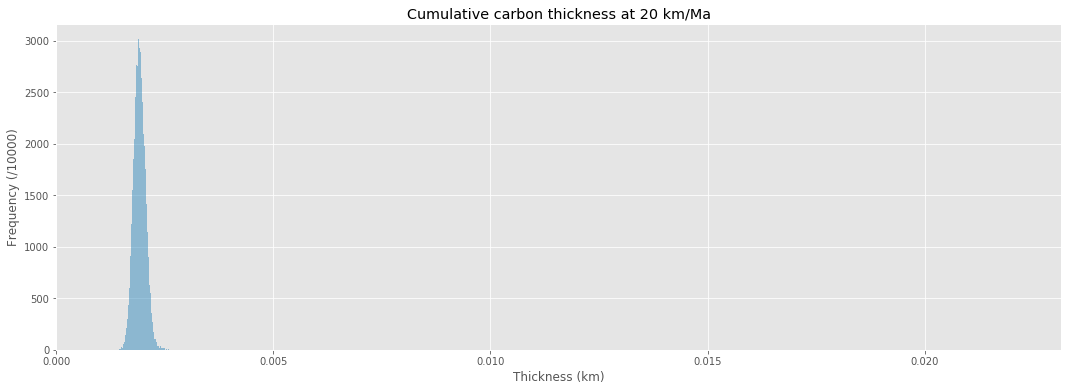

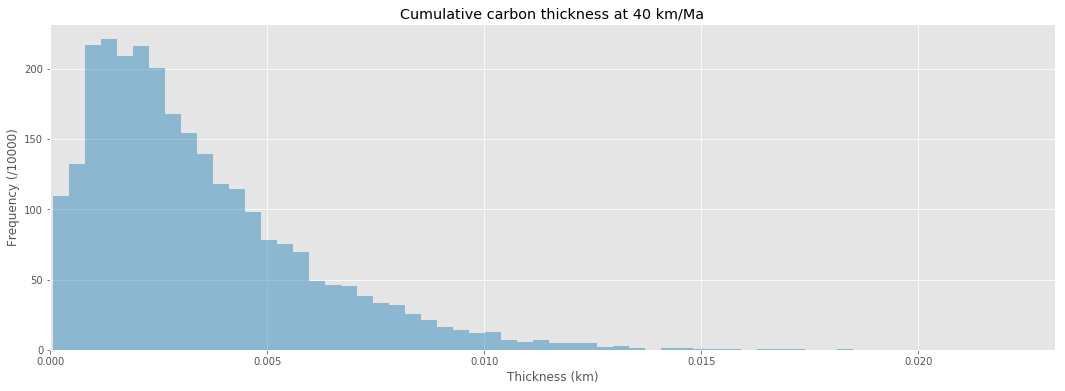

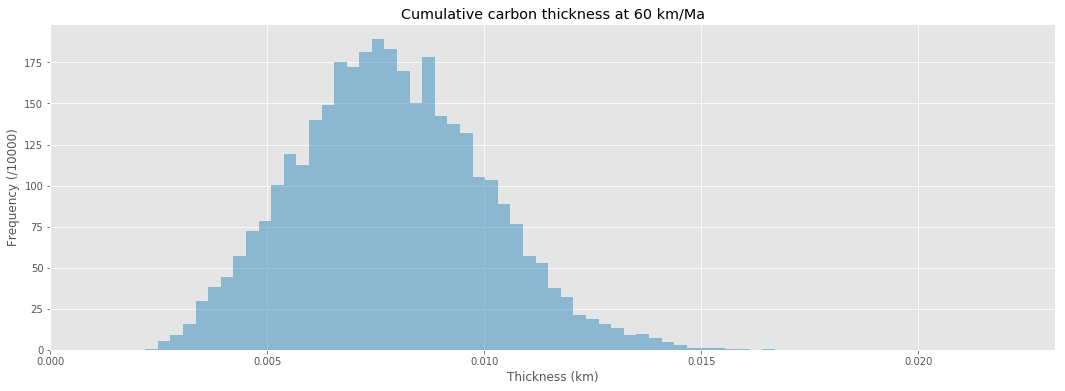

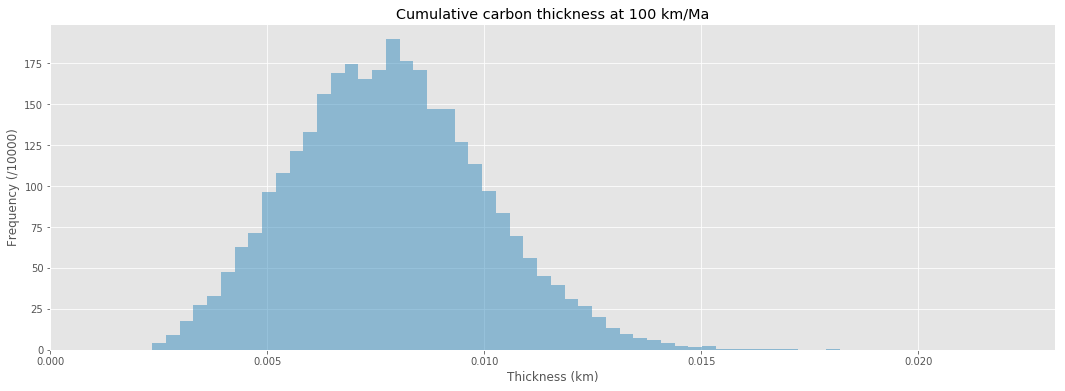

In [11]:
#histograms of each dataset
#carbon first, just at five spreading rates

#for j in np.arange(1,101,1):
for j in [1,20,40,60,100]:
    i = j-1
    data = pd.Series(C_total[i,::])
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])
    ax.set_title('Cumulative carbon thickness at %s km/Ma' % j)
    ax.set_xlabel('Thickness (km)')
    ax.set_ylabel('Frequency (/10000)')
    ax.set_xlim(0,np.max(C_total))

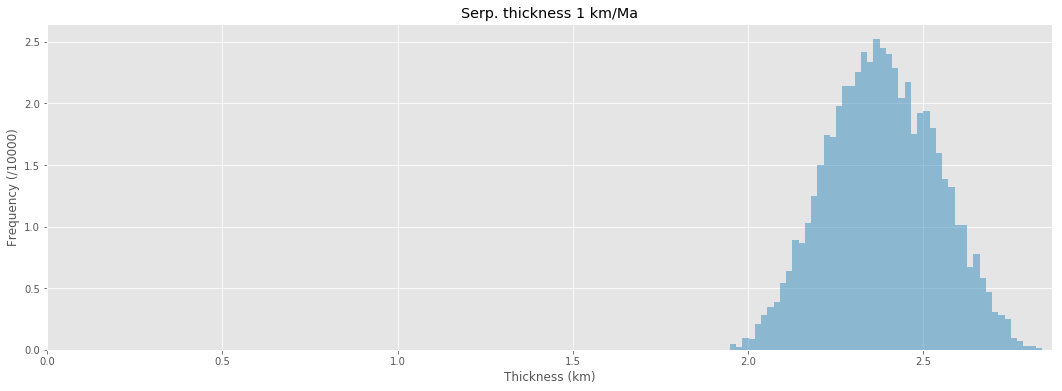

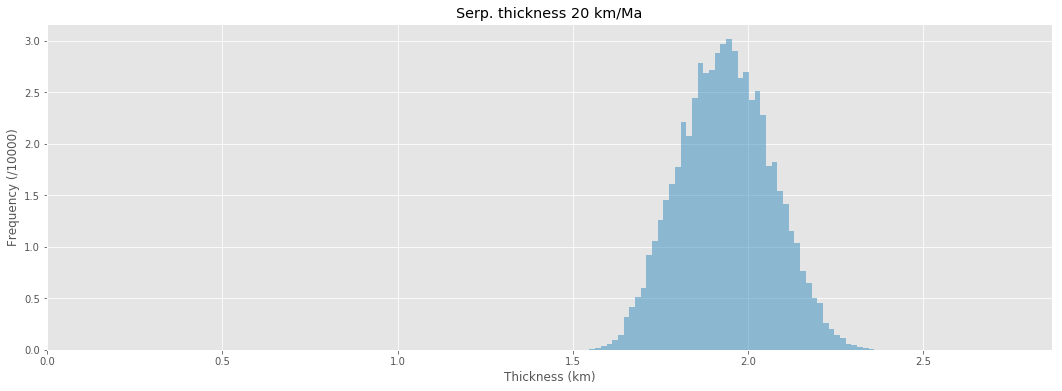

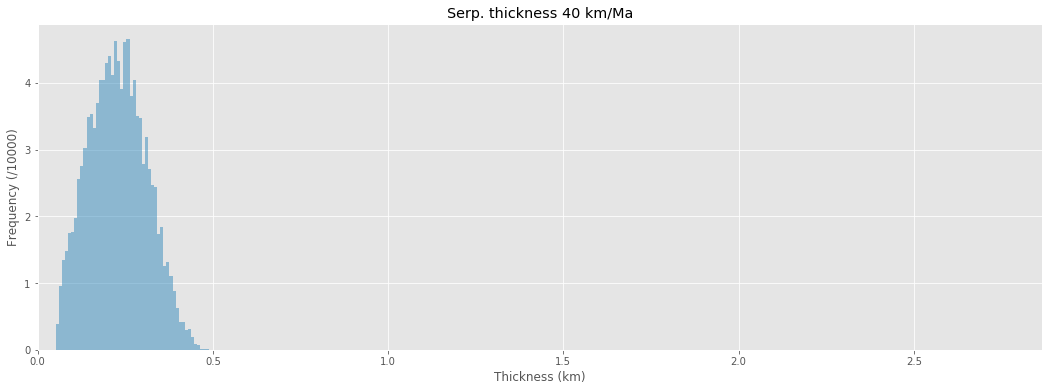

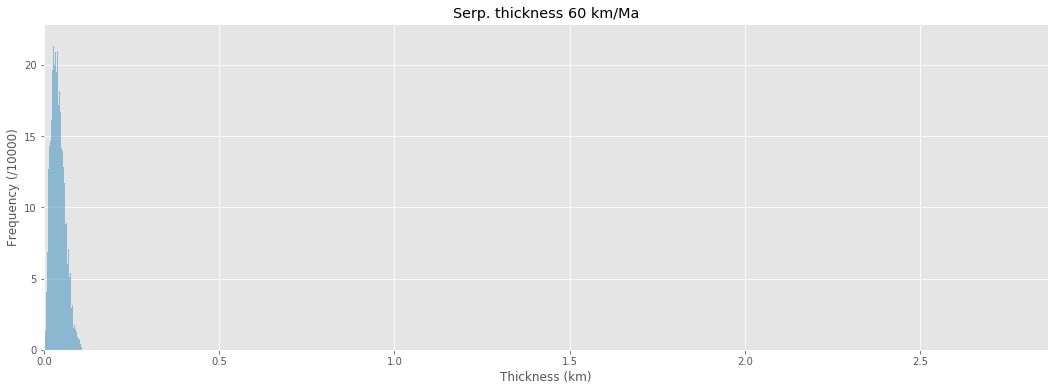

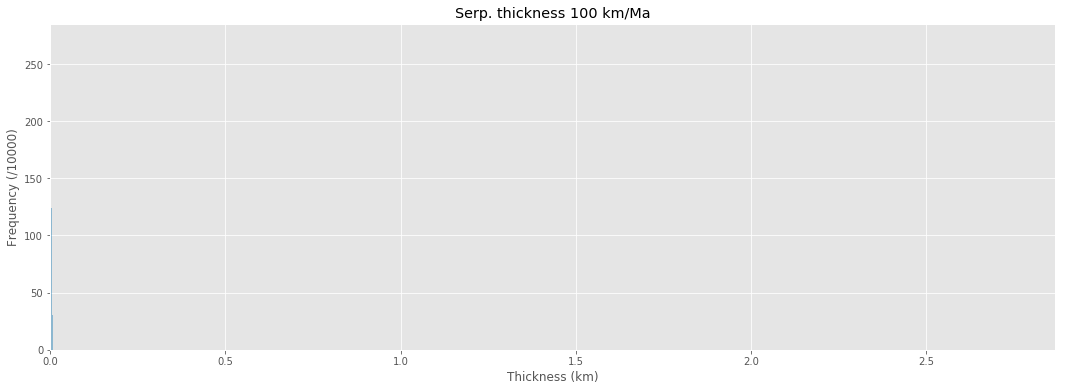

In [12]:
#histograms of each dataset
#Serp now, just at five spreading rates
#for j in range(1,101+1):
for j in [1,20,40,60,100]:   
    i = j-1
    data = pd.Series(serp_thickness[i,::])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
    ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

    ax.set_title('Serp. thickness %s km/Ma' % j)
    ax.set_xlabel('Thickness (km)')
    ax.set_ylabel('Frequency (/10000)')
    ax.set_xlim(0,np.max(serp_thickness))

The below two panels plot the histogram of each slice, and then loop through the distributions in scipy.stats to find a best fit distribution and plot that a well. Part of this code was taken from stackoverflow, written by  'tmthydvnprt' (see distribution_calculator.py for url). (NB: I don't think I actually will end up using it, I just think it's cool).

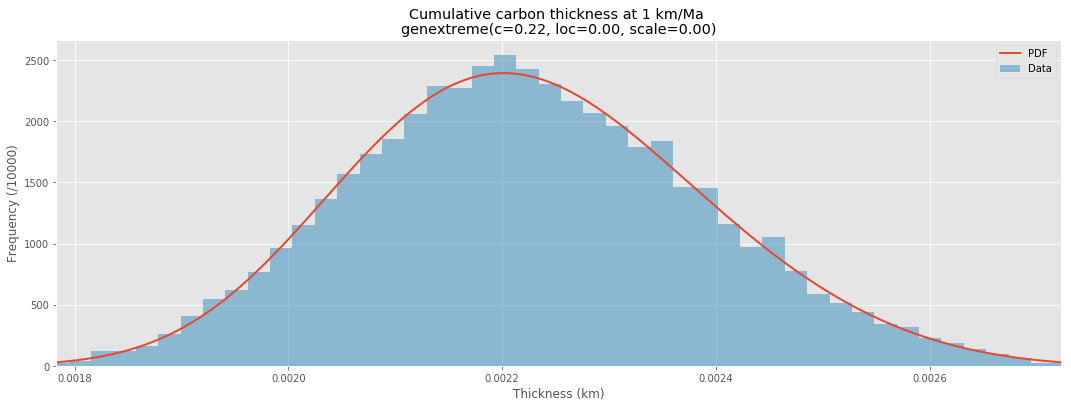

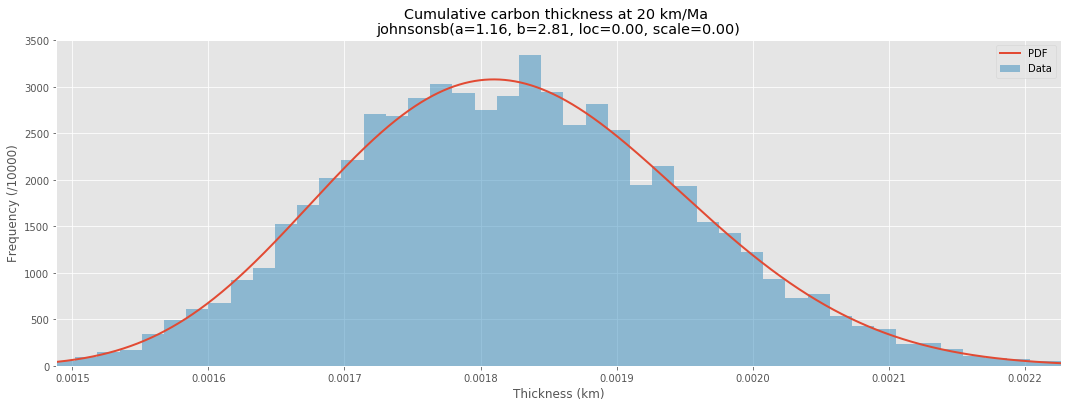

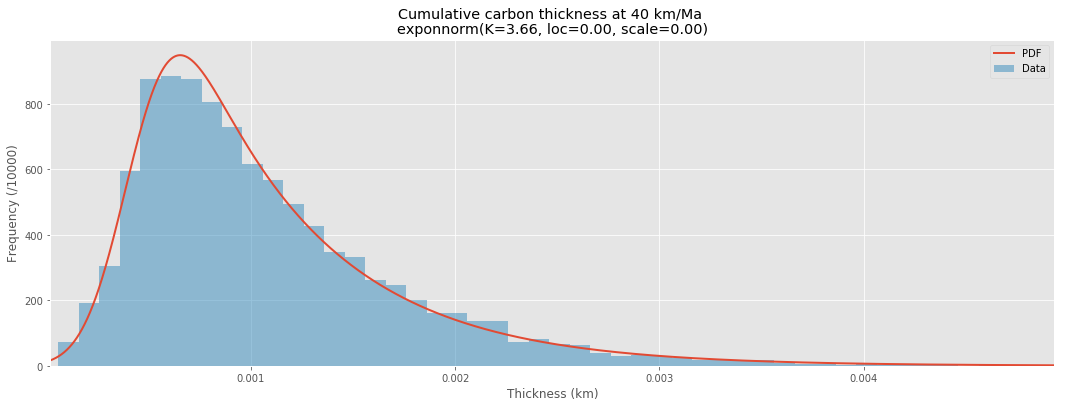

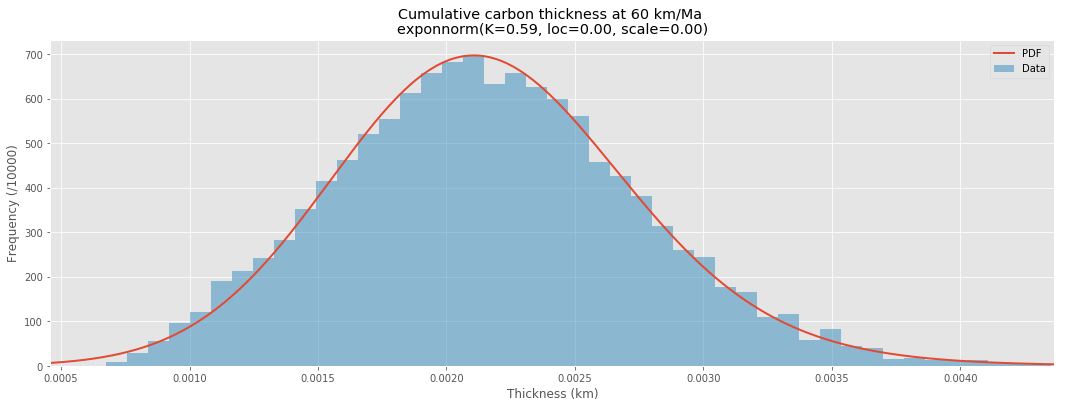

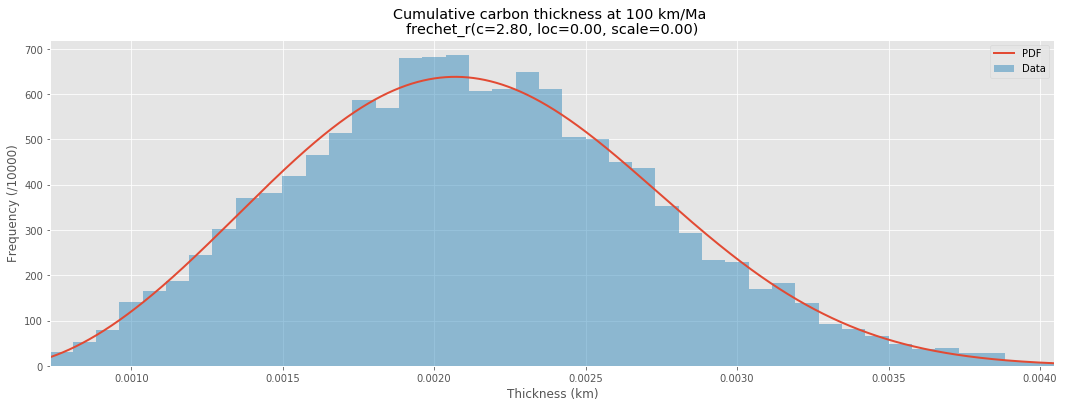

In [44]:
#for j in range(1,100+1):
for j in [1,20,40,60,100]:
    i = j-1
    data = pd.Series(C_total[i,::])
    #get best fitting data
    best_fit_name, best_fit_params = distribution_calculator.best_fit_distribution(data, 200)
    best_dist = getattr(st, best_fit_name)
    
    #Make PDF with best parameters 
    pdf = distribution_calculator.make_pdf(best_dist, best_fit_params)

    #Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
    #plot PDF
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    #plot the data
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)
    ax.set_title('Cumulative carbon thickness at %s km/Ma \n' % j + dist_str )
    ax.set_xlabel('Thickness (km)')
    ax.set_ylabel('Frequency (/10000)')

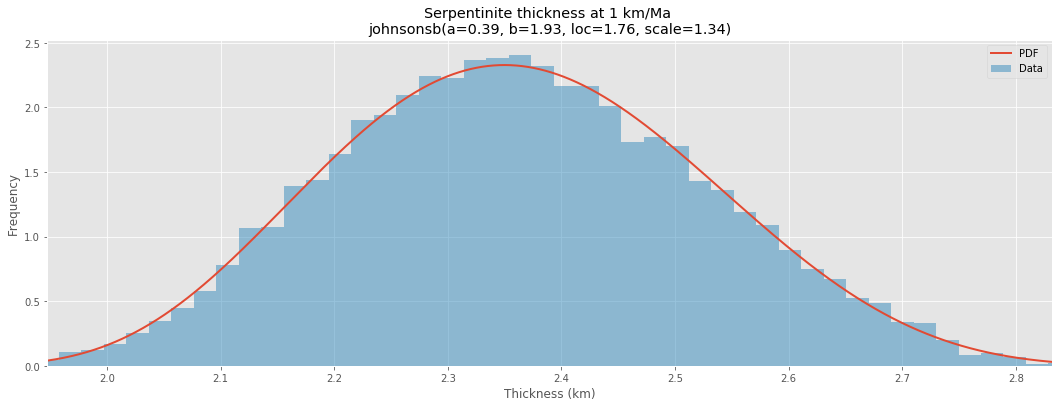

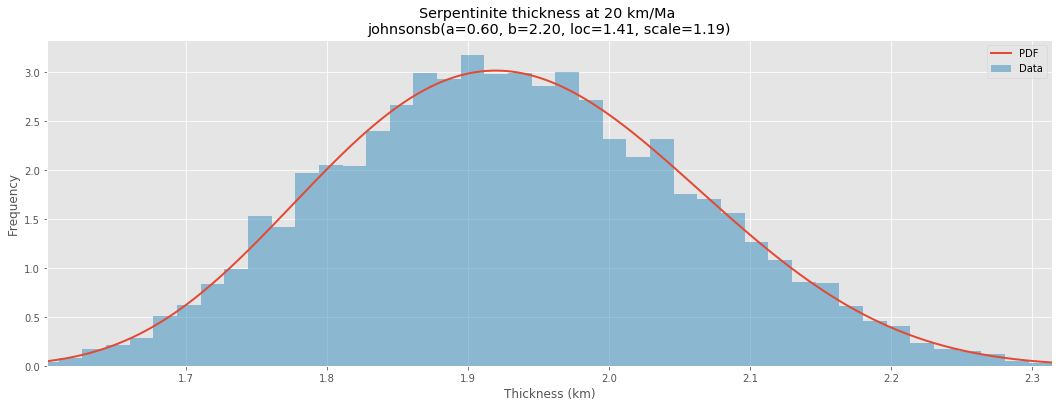

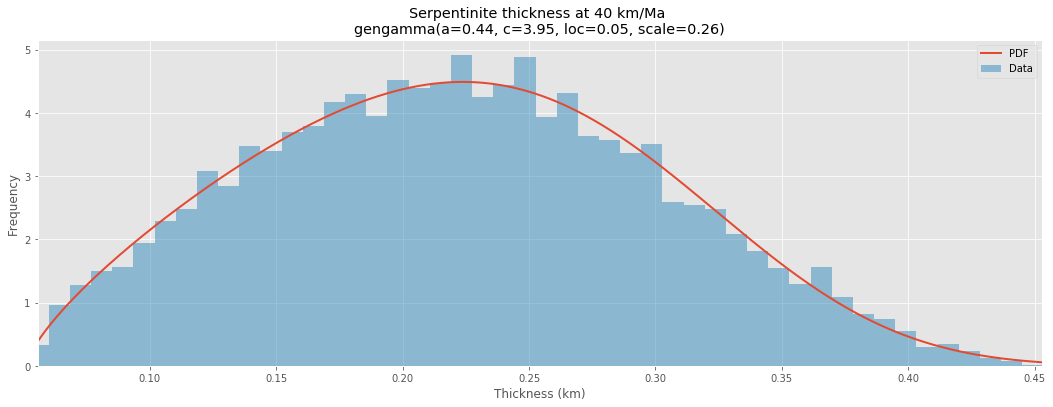

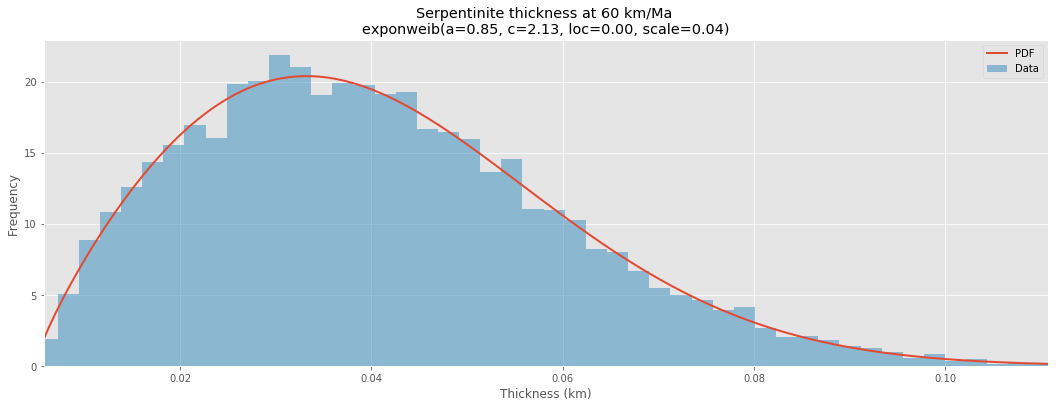

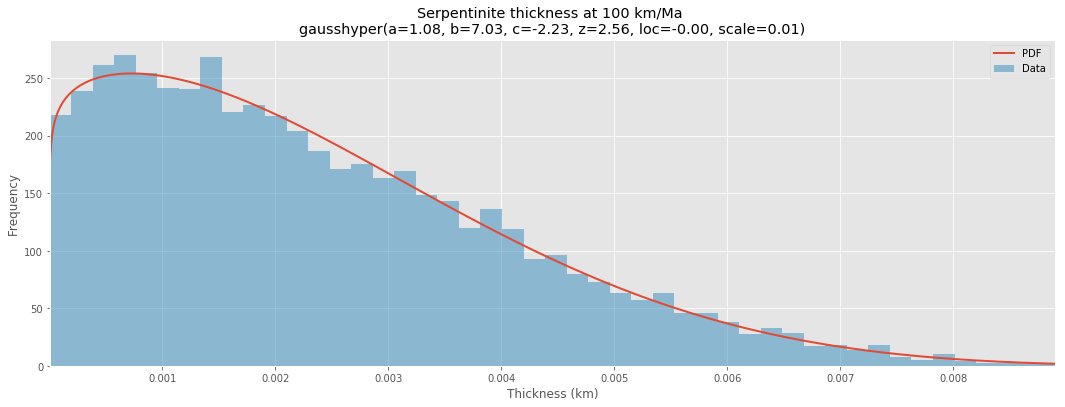

In [45]:
#for j in range(1,100+1):
for j in [1,20,40,60,100]:    
    i = j-1
    data = pd.Series(serp_thickness[i,::])
   #get best fitting data
    best_fit_name, best_fit_params = distribution_calculator.best_fit_distribution(data, 200)
    best_dist = getattr(st, best_fit_name)
    
    #Make PDF with best parameters 
    pdf = distribution_calculator.make_pdf(best_dist, best_fit_params)

    #Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,6))
    #plot PDF
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    #plot the data
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)
    ax.set_title('Serpentinite thickness at %s km/Ma \n' % j + dist_str )
    ax.set_xlabel('Thickness (km)')
    ax.set_ylabel('Frequency')